# Compression d'une image

In [1]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import comnumfip as cnf
from scipy.fftpack import dctn, idctn

In [2]:
def comp_rate(original,compressed):
    # Calcul du taux de compression
    compressed = np.array(compressed).ravel()
    original   = np.array(original).ravel()
    return len(compressed) / len(original)

La source est une image de taille 128 × 128 = 16 384 pixels.
L'ensemble des pixels possibles constitue l'alphabet de la source : il y a $M=$ 256 niveaux de gris possible.

A priori, chaque niveau de gris est équiprobable
(rien n'indique que les images contiennent, par exemple, plus de pixels noirs que de pixels blancs).

L'entropie d'une source de $M$ symboles équiprobables est $\mathrm{log}_2(M)$.
Donc ici, l'entropie est $H(X) = \mathrm{log}_2(256) = 8$ Sh/Symb.

Cela implique que la longueur moyenne minimale d'un code est de 8 bits/symb, soit 1 octet/symb, si on interdit une perte d'information.
Une image de 128 × 128 pixels pèse donc 131 072 bits soit 16 384 octets.

## Image non compressée

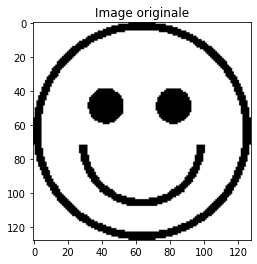

In [13]:
# Chargement de l'image
f = ["smiley.png", "schtroumpf.png", "boat.png"]
img = io.imread(f[0])

# Affichage
plt.figure(figsize=(4,4))
plt.imshow(img, cmap="gray")
plt.title("Image originale")
plt.show()

# Taille (en bits) de l'image
nbits = 8

# Dimension de l'image
m, n = img.shape

## Compression RLE

In [4]:
# Compression RLE
msg = img.ravel()
rle = cnf.rleenc(msg)

# Taille de l'image originale
print(f"Image originale : {m}×{n} = {m*n} symboles codés sur {nbits} bits = {m*n*nbits} bits")

# Taille de l'image compressée en RLE
print(f"Image compressée :          {len(rle)} symboles codés sur {nbits} bits = {len(rle)*nbits} bits")

# Taux de compression en RLE
taux = comp_rate(img, rle)
print(f"soit un taux de compression : {taux*100:.0f} %")

Image originale : 128×128 = 16384 symboles codés sur 8 bits = 131072 bits
Image compressée :          29746 symboles codés sur 8 bits = 237968 bits
soit un taux de compression : 182 %


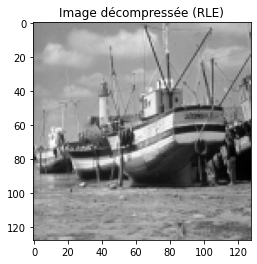

In [5]:
# Décompression RLE

rec = cnf.rledec(rle)
rec = np.reshape(rec, (128,128))

plt.figure(figsize=(4,4))
plt.imshow(rec, cmap="gray")
plt.title("Image décompressée (RLE)")
plt.show()

## Compression JPEG

### Images de base de la DCT

Avant de commencer, il est intéressant d'afficher les images de base de la DCT.
Dans l'exemple ci-dessous, on considère une image de taille 8×8 : il y a donc 64 coefficients de la DCT.

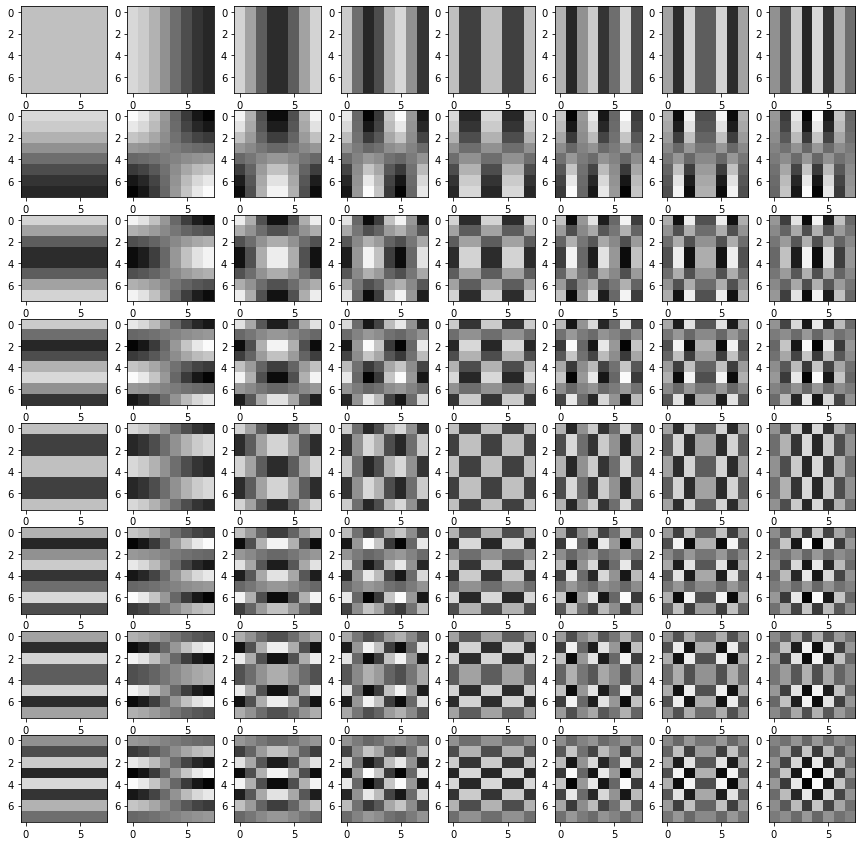

In [6]:
# Pour afficher toute la base
i = 0
plt.figure(figsize=(15,15))
for r in range(8):
    for c in range(8):
        i += 1
        X = np.zeros((8,8))
        X[r,c] = 1
        x = idctn(X, norm='ortho')
        plt.subplot(8,8,i)
        plt.imshow(x, cmap="gray", vmin=-.25, vmax=.25)

En particulier, voici quelques exemples d'images de la base (sur la première ligne) et de leur DCT (sur la seconde ligne) pour une taille de 8×8 pixels.

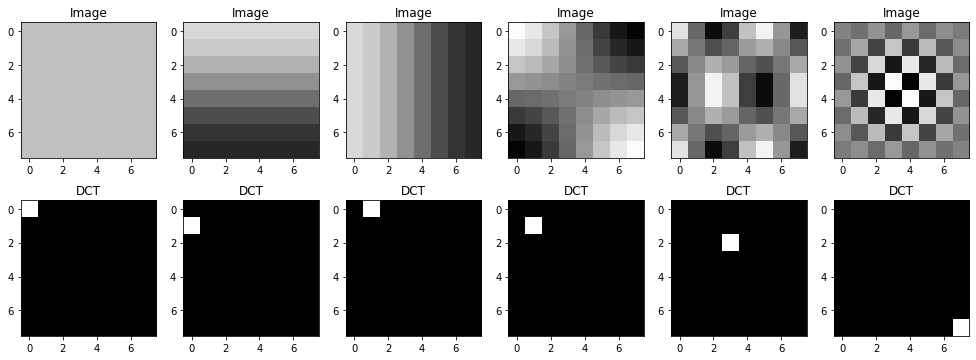

In [7]:
# Pixels (dans le domaine de la DCT) à considérer
px = ( (0,0), (1,0), (0,1), (1,1), (2,3), (7,7) )
I = len(px)

plt.figure(figsize=(17,6))

for i, p in enumerate(px):
    
    # DCT (nulle partout sauf au pixel p)
    X = np.zeros((8,8))
    X[p] = 1
    
    # DCT inverse (ne pas oublier l'option norm='ortho' !)
    x = idctn(X, norm='ortho')
    
    # Affichage de l'image de la base
    plt.subplot(2,I,i+1)
    plt.imshow(x, cmap='gray', vmin=-.25, vmax=.25)
    plt.title('Image')
    
    # Affichage de la DCT
    plt.subplot(2,I,i+I+1)
    plt.imshow(X, cmap='gray')
    plt.title('DCT')

Image originale : 128×128 = 16384 symboles codés sur 8 bits = 131072 bits
Image compressée :          8001 symboles codés sur 8 bits = 64008 bits
soit un taux de compression : 49 %
RSB : 21.72 dB


/home/vincent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/home/vincent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log


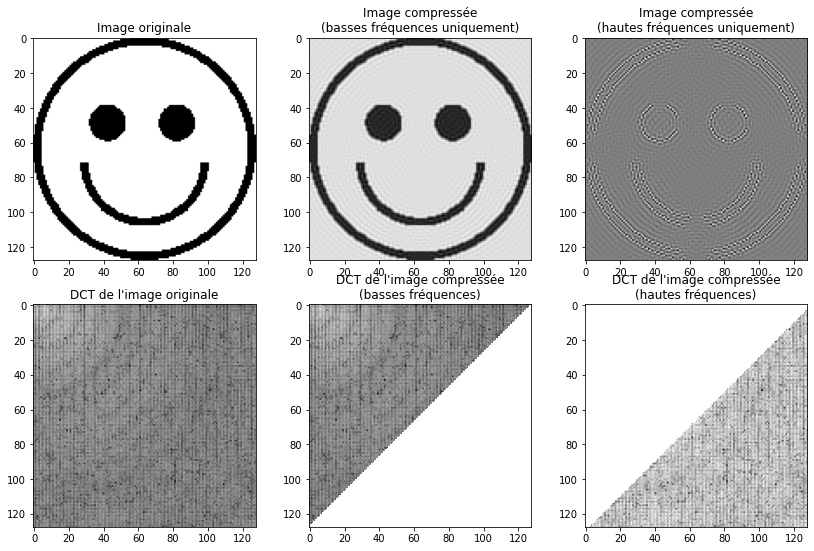

In [15]:
# Transformée en cosinus discrète
I = dctn(img, norm='ortho')

# Compression par annulation des hautes fréquences
M, N = I.shape              # Taille de la DCT I
m = np.arange(M)            # Liste des indices des lignes
n = np.arange(N)            # Liste des indices des colonnes
X, Y = np.meshgrid(m,n)     # Matrices des coordonnées
F = 0.5                     # Facteur de compression (entre 0 et 1)
mask = ((X+Y) < 2*M*F)      # Définit un masque triangulaire
J = I*mask                  # Masquage de l'image
tcd = idctn(J, norm='ortho')

# Compression par annulation des hautes fréquences
mask = ((X+Y) > 2*M*F)      # Définit un masque triangulaire
K = I*mask                  # Masquage de l'image
tcd2 = idctn(K, norm='ortho')

# Taille de l'image originale
m, n = img.shape
print(f"Image originale : {m}×{n} = {m*n} symboles codés sur {nbits} bits = {m*n*nbits} bits")

# Taille de l'image compressée en JPEG
tmp = np.nonzero(mask.ravel())[0]
print(f"Image compressée :          {len(tmp)} symboles codés sur {nbits} bits = {len(tmp)*nbits} bits")

# Taux de compression en JPEG
taux = comp_rate(img, tmp)
print(f"soit un taux de compression : {taux*100:.0f} %")

# RSB
D = 2**8 - 1
PI = np.linalg.norm(img)**2 / (M*N)
eqm = np.linalg.norm(img-tcd)**2 / (M*N)
rsb = 10*np.log10(PI/eqm)
print(f"RSB : {rsb:.2f} dB")

# Affichage
fig, axs = plt.subplots(2,3, figsize=(14,9))
axs[0][0].imshow(img, cmap="gray")
axs[0][0].set_title("Image originale")
axs[0][1].imshow(tcd, cmap="gray")
axs[0][1].set_title("Image compressée\n(basses fréquences uniquement)")
axs[0][2].imshow(tcd2, cmap="gray")
axs[0][2].set_title("Image compressée\n(hautes fréquences uniquement)")

axs[1][0].imshow(np.log(np.absolute(I)), cmap="gray")
axs[1][0].set_title("DCT de l'image originale")
axs[1][1].imshow(np.log(np.absolute(J)), cmap="gray")
axs[1][1].set_title("DCT de l'image compressée\n(basses fréquences)")
axs[1][2].imshow(np.log(np.absolute(K)), cmap="gray")
axs[1][2].set_title("DCT de l'image compressée\n(hautes fréquences)")
plt.show()

In [ ]:


# ## DCT sur des sous-images

# sub = 16;               # Taille des sous-images

# # Affichage de l'image originale
# figure;
# # subplot(2,5,1);
# # imshow(img,[0 255]);
# # labels('x','','Image originale','Image subdivisée');

# for taux = 0:0.1:1,     # taux de compression

#     for i = 1:sub:m,

#         for j = 1:sub:n,

#             img2 = img( i:(i+sub-1) , j:(j+sub-1) );    # Sous-image
#             I = dct2(img2);                             # Transformée
#             [X,Y] = meshgrid(1:sub,1:sub);
#             M = (X+Y) <= 2*sub*taux;
#             J = I.*M;
#             tcd2 = idct2(J);                            # Transformation inverse
#             tcd( i:(i+sub-1) , j:(j+sub-1) ) = tcd2;    # Enregistrement dans l'image originale
            
#         end;

#     end;
    
#     # PSNR
#     D = 2^8 - 1;
#     eqm = 1/(m*n) * sum((img(:)-tcd(:)).^2);
#     psnr = 10*log10(D^2/eqm);

#     # Affichage
#     subplot(2,6,taux*10+2);
#     imshow(tcd,[0 255]);
#     labels(['PSNR = ' num2str(round(psnr)) ' dB'],'',[num2str(taux*100) ' %']);
    
# end;

# # Image originale
# subplot(2,6,1);
# imshow(img,[0 255]);
# labels('','','Image originale','Image subdivisée');

# beamer;


In [ ]:

## Test : quel est le meilleur type de seuillage ?
# Réponse : en triangle

# close all;
# clc;
# 
# I = dct2(img);
# D = 2^8 - 1;
# figure;
# imshow(img,[0 255],'InitialMagnification',100);
# labels('','','Image originale','Originale');
# 
# # L
# idx = 1:sqrt(.5)*m;
# J1 = zeros(m,n);
# J1(idx,idx) = I(idx,idx);
# tcdsize = length(idx)^2;
# tcd = idct2(J1);
# eqm = 1/(m*n) * sum((img(:)-tcd(:)).^2);
# psnr = 10*log10(D^2/eqm);
# fprintf('  PSNR1 : #.2f dB\n', psnr);
# figure;
# imshow(tcd,[0 255],'InitialMagnification',100);
# labels('','','compressée 1','Compressée');
# figure;
# imshow(log(abs(J1)),[]);
# labels('','','DCT 1','Tout');
# 
# # Triangle
# [X,Y] = meshgrid(1:m,1:n);
# M = (X+Y) < m;
# J2 = I.*M;
# tcdsize = sum(M(:));
# tcd = idct2(J2);
# eqm = 1/(m*n) * sum((img(:)-tcd(:)).^2);
# psnr = 10*log10(D^2/eqm);
# fprintf('  PSNR1 : #.2f dB\n', psnr);
# figure;
# imshow(tcd,[0 255],'InitialMagnification',100);
# labels('','','compressée 2','Compressée');
# figure;
# imshow(log(abs(J2)),[]);
# labels('','','DCT 2','Tout');
# 
# # Rond
# [X,Y] = meshgrid(1:m,1:n);
# M = (X.^2+Y.^2)<2/pi*m^2;
# J3 = I.*M;
# tcd = idct2(J3);
# eqm = 1/(m*n) * sum((img(:)-tcd(:)).^2);
# psnr = 10*log10(D^2/eqm);
# fprintf('  PSNR1 : #.2f dB\n', psnr);
# figure;
# imshow(tcd,[0 255],'InitialMagnification',100);
# labels('','','compressée 3','Compressée');
# figure;
# imshow(log(abs(J3)),[]);
# labels('','','DCT 3','Tout');
# 
# # Carré
# idx = round((1-sqrt(.5))*m):m;
# J4 = I;
# J4(idx,idx) = 0;
# tcdsize = length(idx)^2;
# tcd = idct2(J4);
# eqm = 1/(m*n) * sum((img(:)-tcd(:)).^2);
# psnr = 10*log10(D^2/eqm);
# fprintf('  PSNR1 : #.2f dB\n', psnr);
# figure;
# imshow(tcd,[0 255],'InitialMagnification',100);
# labels('','','compressée 4','Compressée');
# figure;
# imshow(log(abs(J4)),[]);
# labels('','','DCT 4','Tout');